In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import copy
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号‘-’显示为方块的问题

In [2]:
link = pd.read_csv('../数据/link_table.csv')
res = pd.read_csv('../数据/response.csv')
tran = pd.read_csv('../数据/transaction.csv')
app = pd.read_csv('../数据/application_record.csv')

D:\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
app['ID'].isin(link['ID']).agg(sum)

4500

In [4]:
tran.head(-1)

,trans_id,account_id,date,type,operation,k_symbol,bank,account,amount_num,balance_num
0,695247,2378,1993-01-01,credit,loan,NaN,NaN,NaN,700.0,700.0
1,171812,576,1993-01-01,credit,loan,NaN,NaN,NaN,900.0,900.0
2,207264,704,1993-01-01,credit,loan,NaN,NaN,NaN,1000.0,1000.0
3,1117247,3818,1993-01-01,credit,loan,NaN,NaN,NaN,600.0,600.0
4,579373,1972,1993-01-02,credit,loan,NaN,NaN,NaN,400.0,400.0
...,...,...,...,...,...,...,...,...,...,...
1056314,3625433,2870,1998-12-31,credit,NaN,interest,NaN,NaN,189.0,44120.0
1056315,3626622,2906,1998-12-31,credit,NaN,interest,NaN,NaN,62.0,13729.0
1056316,3627616,2935,1998-12-31,credit,NaN,interest,NaN,NaN,81.0,19545.0
1056317,3625403,2869,1998-12-31,credit,NaN,interest,NaN,NaN,60.0,14638.0


#### 计算RFM

In [5]:
# 账户号映射客户号
id_dic = link.set_index('account_id')['ID'].to_dict()
tran['ID'] = tran['account_id'].apply(lambda x: id_dic[x])
# 距1998-6-30的交易时间/天
tran['date'] = tran['date'].astype('datetime64') # date转为时间格式 pd.to_datetime(tran['date'])
tran['tran_time'] = datetime(1998,6,30) - tran['date']
# tran_view    选取观察窗口 1998-1-1 至 1998-6-30
tran_view = tran[tran['date']>='1998-1-1'][tran['date']<='1998-6-30']

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
id_rfm = pd.DataFrame(columns=['ID','R','F','M'])
id_rfm['ID'] = tran_view.drop_duplicates('ID',keep='last')['ID']
id_rfm['R'] = tran_view.drop_duplicates('ID',keep='last')['tran_time'].apply(lambda x: x.days)
# 字典映射频次
F_dic = tran_view['ID'].value_counts().to_dict() 
id_rfm['F'] = id_rfm['ID'].apply(lambda x: F_dic.setdefault(x,0))
# 字典映射总金额
M_dic = tran_view.groupby('ID')['amount_num'].agg(sum).to_dict()
id_rfm['M'] = id_rfm.ID.apply(lambda x: M_dic.setdefault(x,0))
id_rfm.set_index('ID',inplace=True)
# id_rfm.to_excel('RFM.xlsx') # 写入excel
id_rfm.head()

,R,F,M
ID,,,
5149514,180,1,5300.0
6575354,165,1,2200.0
5945612,150,3,3401.0
6209733,142,2,2900.0
5906133,116,3,5100.0


#### RFM分档

In [7]:
# plt.hist(id_rfm.R)
pd.cut(id_rfm.R,bins=[-1,0,np.inf]).value_counts()

(-1.0, 0.0]    4440
(0.0, inf]       50
Name: R, dtype: int64

(0.0, 40.0]    2879
(40.0, inf]    1611
Name: F, dtype: int64

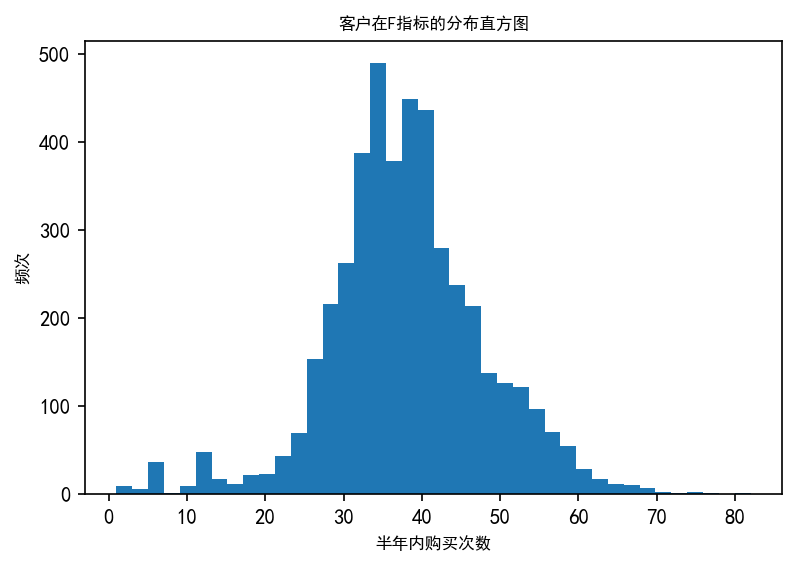

In [8]:
plt.figure(dpi=150,) #  figsize=(2,1.7)
plt.hist(id_rfm.F,bins=40); plt.title('客户在F指标的分布直方图',fontsize=8); plt.xlabel('半年内购买次数',fontsize=8); plt.ylabel('频次',fontsize=8)
pd.cut(id_rfm.F,bins=[0,40,np.inf],precision=0).value_counts().sort_index()

(0.0, 310000.0]    3543
(310000.0, inf]     947
Name: M, dtype: int64

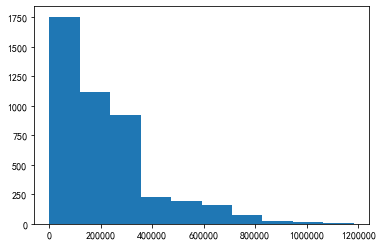

In [9]:
# 二八定律/帕累托法则
plt.hist(id_rfm.M,bins=10)
pd.cut(id_rfm.M,[0,310000,np.inf],precision=0).value_counts().sort_index() # pd.qcut(id_rfm.M,[0,.8,1],precision=0).value_counts().sort_index()

In [10]:
level_rfm = copy.deepcopy(id_rfm)
level_rfm['R'] = level_rfm['R'].apply(lambda x: '高' if x==0 else '低')
level_rfm['F'] = level_rfm['F'].apply(lambda x: '低' if x<=40 else '高')
level_rfm['M'] = level_rfm['M'].apply(lambda x: '低' if x<=310000 else '高')
level_rfm.head()

,R,F,M
ID,,,
5149514,低,低,低
6575354,低,低,低
5945612,低,低,低
6209733,低,低,低
5906133,低,低,低


In [11]:
kind_dic = {'高高高':'重要价值客户','高低高':'重要发展客户',
    '低高高':'重要保持客户','低低高':'重要挽留客户',
    '高高低':'一般价值客户','高低低':'一般发展客户',
    '低高低':'一般保持客户','低低低':'一般挽留客户'}
level_rfm['label'] = level_rfm.apply(lambda x: kind_dic[x.values.sum()] ,axis=1)

In [12]:
pd.DataFrame(level_rfm['label'].value_counts())

,label
一般发展客户,2498
一般价值客户,995
重要价值客户,616
重要发展客户,331
一般挽留客户,50


In [13]:
level_rfm['label'].value_counts()

一般发展客户    2498
一般价值客户     995
重要价值客户     616
重要发展客户     331
一般挽留客户      50
Name: label, dtype: int64

In [17]:
# label_list= ['重要价值客户','重要发展客户',
#     '重要保持客户','重要挽留客户',
#     '一般价值客户','一般发展客户',
#     '一般保持客户','一般挽留客户']
# for k in label_list:
#     level_rfm[k] = level_rfm['label'].apply(lambda x: 1 if x==k else 0)
    
level_rfm.to_csv('../数据/rfm_label.csv') # 保存到csv